In [1]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as F
import cv2
import matplotlib.pyplot as plt
from PIL import Image

/home/zhouziyang/anaconda3/envs/pytorch/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_path = "data/wallhaven-wed2qq_1920x1080.png"

In [3]:
# read image with PIL
pil_img = Image.open(img_path) # RGBA
print(f"Before converting to RGB: {np.asarray(pil_img).shape}") # [h, w, c] RGBA
pil_img = pil_img.convert("RGB") # return Image object
print(f"PIL image size: {pil_img.size}") # [w, h]
print(f"image height: {pil_img.height}, image width: {pil_img.width}")
print(f"After converting to RGB: {np.asarray(pil_img).shape}") # [h, w, c] RGB

Before converting to RGB: (1080, 1920, 4)
PIL image size: (1920, 1080)
image height: 1080, image width: 1920
After converting to RGB: (1080, 1920, 3)


In [4]:
# read image with cv2
cv2_img = cv2.imread("data/wallhaven-wed2qq_1920x1080.png") # return ndarray
print(f"cv2 image size: {cv2_img.shape}") # [h, w, c] BGR

cv2 image size: (1080, 1920, 3)


In [5]:
# PIL to tensor
pil2tensor = F.to_tensor(pil_img) 
print(f"torch tensor shape: {pil2tensor.shape}") # [c, h, w] RGB
print(pil2tensor[0])

torch tensor shape: torch.Size([3, 1080, 1920])
tensor([[0.5020, 0.4980, 0.5020,  ..., 0.5294, 0.5216, 0.5216],
        [0.4980, 0.5020, 0.5020,  ..., 0.5216, 0.5176, 0.5216],
        [0.4980, 0.5020, 0.5020,  ..., 0.5216, 0.5216, 0.5216],
        ...,
        [0.3922, 0.3961, 0.3961,  ..., 0.1529, 0.1490, 0.1451],
        [0.4000, 0.4000, 0.4000,  ..., 0.1490, 0.1490, 0.1529],
        [0.4235, 0.4235, 0.4196,  ..., 0.1490, 0.1451, 0.1490]])


In [6]:
# cv2 to tensor: 
cv2tensor = F.to_tensor(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))
print(f"torch tensor shape: {cv2tensor.shape}") # [c, h, w] RGB

torch tensor shape: torch.Size([3, 1080, 1920])


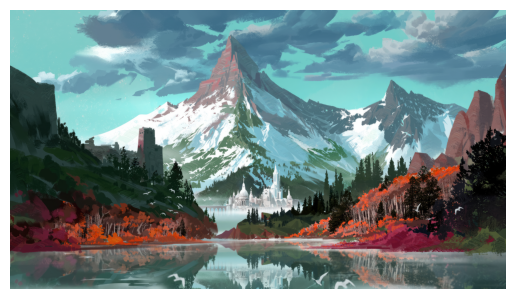

In [7]:
# visualize pil image using matplot lib
fig, ax = plt.subplots()
ax.imshow(pil_img)
ax.axis("off")
plt.show()

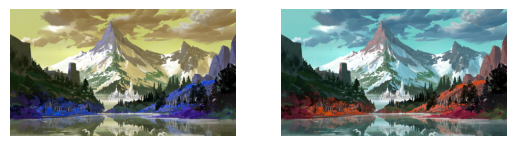

In [8]:
# visualize cv2 image using matplot lib
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(cv2_img) # BGR
axs[0].axis("off")
axs[1].imshow(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)) # RGB
axs[1].axis("off")
plt.show()

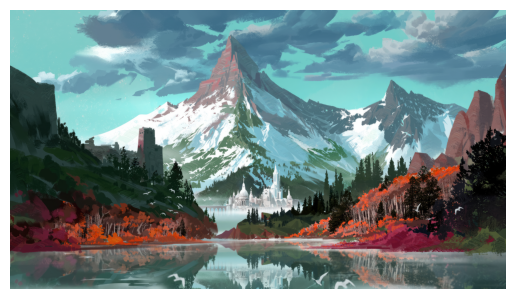

In [9]:
# tensor to PIL
tensor2pil = F.to_pil_image(pil2tensor)
fig, ax = plt.subplots()
ax.imshow(tensor2pil)
ax.axis("off")
plt.show()

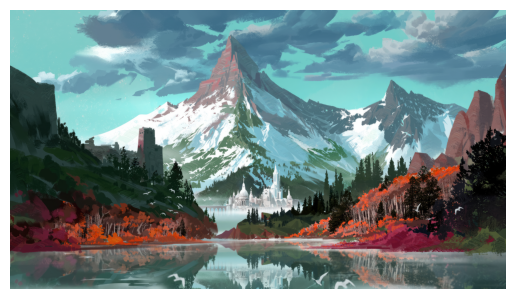

In [10]:
# or tensor to PIL (copy from https://pytorch.org/vision/stable/_modules/torchvision/utils.html#save_image) 
ndarr = pil2tensor.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
tensor2pil = Image.fromarray(ndarr)
fig, ax = plt.subplots()
ax.imshow(tensor2pil)
ax.axis("off")
plt.show()

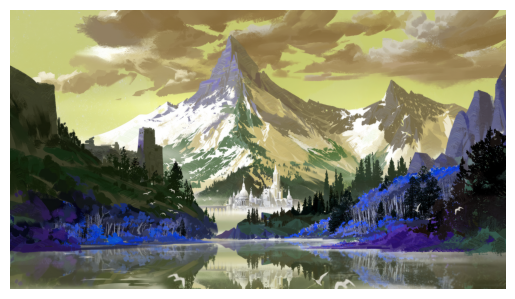

In [11]:
# tensor to cv2: [c, h, w] RGB 0-1 -> [h, w, c] BGR 0-255
tensor2cv = np.asarray(cv2tensor.mul(255).byte()).transpose(1, 2, 0)
tensor2cv = cv2.cvtColor(tensor2cv, cv2.COLOR_RGB2BGR)
fig, ax = plt.subplots()
ax.imshow(tensor2cv)
ax.axis("off")
plt.show()

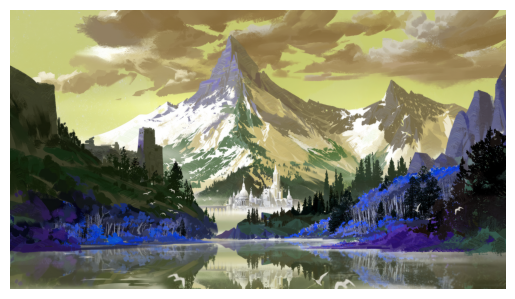

In [12]:
# PIL to cv2
pil2cv = np.asarray(pil_img)
pil2cv = cv2.cvtColor(pil2cv, cv2.COLOR_RGB2BGR)
fig, ax = plt.subplots()
ax.imshow(pil2cv)
ax.axis("off")
plt.show()

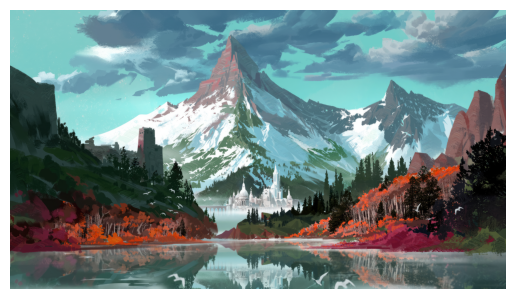

In [13]:
# cv2 to PIL
cv2pil = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB)
cv2pil = Image.fromarray(cv2pil)
fig, ax = plt.subplots()
ax.imshow(cv2pil)
ax.axis("off")
plt.show()

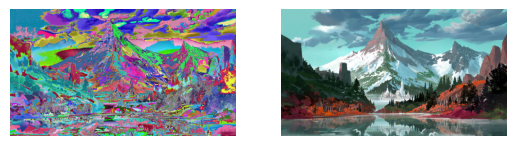

In [14]:
# visualize normalized tensor
import torchvision.transforms as transforms

normalize_param = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

img = Image.open(img_path).convert("RGB")
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(**normalize_param)])

# version by myself
# def denormalize(x, mean, std):
#     """
#     Parameters:
#     x (Tensor): image tensor with shape [c, h, w]
#     mean (sequence): Sequence of means for each channel.
#     std (sequence): Sequence of standard deviations for each channel.

#     Returns:
#     denormalized image tensor.
#     """
#     c, h, w = x.shape
#     mean = torch.tensor(mean).unsqueeze(-1).expand([c, h*w]).view_as(x)
#     std = torch.tensor(std).unsqueeze(-1).expand([c, h*w]).view_as(x)
#     return x * std + mean

def denormalize(tensor, mean, std):
    """
    Parameters:
        tensor (Tensor): Float tensor image of size (C, H, W) or (B, C, H, W) to be normalized.
        mean (sequence): Sequence of means for each channel.
        std (sequence): Sequence of standard deviations for each channel.

    Returns:
        Tensor: Normalized Tensor image.
    """
    dtype = tensor.dtype
    mean = torch.as_tensor(mean, dtype=dtype, device=tensor.device)
    std = torch.as_tensor(std, dtype=dtype, device=tensor.device)
    if (std == 0).any():
        raise ValueError(f"std evaluated to zero after conversion to {dtype}, leading to division by zero.")
    if mean.ndim == 1:
        mean = mean.view(-1, 1, 1)
    if std.ndim == 1:
        std = std.view(-1, 1, 1)
    return tensor.mul_(std).add_(mean)


tensor = trans(img)
fig, axs = plt.subplots(ncols=2)
axs[0].imshow(F.to_pil_image(tensor))
axs[0].axis("off")
axs[1].imshow(F.to_pil_image(denormalize(tensor, **normalize_param)))
axs[1].axis("off")
plt.show()

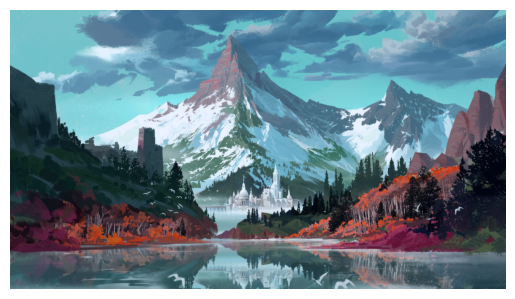

In [15]:
# test make_grid
normalize_param = dict(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

img = Image.open(img_path).convert("RGB")
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize(**normalize_param)])
tensor = trans(img).unsqueeze(0)

tmp = torchvision.utils.make_grid(tensor, normalize=True, scale_each=True)
fig, ax = plt.subplots()
ax.imshow(F.to_pil_image(tmp))
ax.axis("off")
plt.show()